In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages/')

In [2]:
from venture.shortcuts import *
import venture.lite.builtin as bp
import venture.lite.types as t
import venture.lite.psp as psp
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from util import *
from collections import defaultdict

%matplotlib inline

In [3]:
v=make_lite_venture_script_ripl()
v.bind_foreign_sp("compute_distance", bp.deterministic_typed(compute_distance2, 
                  [t.NumberType()]*3,t.NumberType()))
v.bind_foreign_sp("compute_azimuth", bp.deterministic_typed(compute_azimuth2, 
                  [t.NumberType()]*3,t.NumberType()))
v.bind_foreign_sp("invert_dist_azimuth2", bp.deterministic_typed(invert_dist_azimuth, 
                  [t.NumberType(),t.NumberType(),t.NumberType()],t.ArrayType(t.NumberType())))

class BoundedExponOutputPSP(psp.RandomPSP):
  # TODO don't need to be class methods
  def simulateNumeric(self,mu,theta,gamma):
    while True:
        x = mu + sp.expon.rvs(scale=1.0/theta)
        if x < gamma:
            return x
  def logDensityNumeric(self,x,mu,theta,gamma):
    if not (mu <= x <= gamma):
        return float('-inf')
    nontailmass = sp.expon.logcdf(gamma - mu,scale=1.0/theta)
    return sp.expon.logpdf(x - mu,scale=1.0/theta) - nontailmass

  def simulate(self,args): return self.simulateNumeric(*args.operandValues())
  def logDensity(self,x,args): return self.logDensityNumeric(x,*args.operandValues())

  def gradientOfLogDensity(self,x,args):
    mu,theta,gamma = args.operandValues()
    nontailmass = sp.expon.cdf(gamma - mu,scale=1.0/theta)
    gradX = -theta
    gradTheta = 1.0 / nontailmass / theta - (x - mu)
    print (gradX,[gradTheta])
    return (gradX,[gradTheta])

  def description(self,name):
    return "  %s(theta) returns a sample from an exponential distribution with rate (inverse scale) parameter theta." % name


v.bind_foreign_sp("bounded_expon", bp.typed_nr(BoundedExponOutputPSP(), [t.NumberType()]*3,t.NumberType()))

## Initialize Priors

In the next block, I initialize all parameters of a physical world description via the prior distributions given in the problem description file. I set the assumptions in my ripl layer while defining the variables locally, then set all local variables into the namedTuple physicsPriors.

In [4]:
lenst = len(STATIONS)

physPriorParamNames = ["T", "R", "lambda_e", "mu_m", "theta_m", "gamma_m", "mu_d0", "mu_d1", "mu_d2",
  "mu_t", "theta_t", "mu_z", "theta_z", "mu_s", "theta_s",
  "mu_a0", "mu_a1", "mu_a2", "sigma_a",
  "lambda_f", "mu_f", "theta_f"]

T = v.assume('T','3600.')
R = v.assume('R','6371.')
lambda_e = v.assume('lambda_e','gamma(6.0,(4*3.1415927*6371**2*3600))')
mu_m = v.assume('mu_m','3.0')
theta_m = v.assume('theta_m','4.0')
gamma_m = v.assume('gamma_m','6.0')
v.assume('mu_d_covar','matrix(list(list(13.43,-2.36,-0.0122),list(-2.36,0.452,0.000112),list(-0.0122,0.000112,0.000125)))')
v.assume('mu_a_covar','matrix(list(list(1.23, -0.227, -0.000175),list(-0.227,0.0461,0.0000245),list(-0.000175,0.0000245,0.000000302)))')

v.assume('mu_d','mem( proc(k) { multivariate_normal(vector(-10.4,3.26,-0.0499),mu_d_covar) })')
v.assume('mu_t','mem( proc(k) { 0.0 } )')
v.assume('theta_t','mem( proc(k) { inv_gamma(120,118) } )')
v.assume('mu_z','mem( proc(k) { 0.0 } )')
v.assume('theta_z','mem( proc(k) { inv_gamma(5.2,44) } )')
v.assume('mu_s','mem( proc(k) { 0.0 } )')
v.assume('theta_s','mem( proc(k) { inv_gamma(6.7,7.5) } )')
v.assume('mu_a','mem( proc(k) { multivariate_normal(vector(-7.3,2.03,-0.00196),mu_a_covar) })')
#v.assume('sigma_a','mem( proc(k) { (inv_gamma(21.1,12.6)**0.5) } )')
v.assume('lambda_f','mem( proc(k) { gamma(2.1,1 / 0.0013) } )')
v.assume('mu_f','mem( proc(k) { normal(-0.68,0.68) } )')
v.assume('theta_f','mem( proc(k) { inv_gamma(23.5,12.45) } )')

mu_d = np.zeros((lenst,3))
mu_t = np.zeros(lenst)
theta_t = np.zeros(lenst)
mu_z = np.zeros(lenst)
theta_z = np.zeros(lenst)
mu_s = np.zeros(lenst)
theta_s = np.zeros(lenst)
mu_a = np.zeros((lenst,3))
sigma_a = np.zeros(lenst)
lambda_f = np.zeros(lenst)
mu_f = np.zeros(lenst)
theta_f = np.zeros(lenst)


pp = []
for i in range(len(STATIONS)):
    mu_d[i] = v.sample('mu_d({0})'.format(i))
    mu_t[i] = v.sample('mu_t({0})'.format(i))
    theta_t[i] = v.sample('theta_t({0})'.format(i))
    mu_z[i] = v.sample('mu_z({0})'.format(i))
    theta_z[i] = v.sample('theta_z({0})'.format(i))
    mu_s[i] = v.sample('mu_s({0})'.format(i))
    theta_s[i] = v.sample('theta_s({0})'.format(i))
    mu_a[i] = v.sample('mu_a({0})'.format(i))
    #sigma_a[i] = v.sample('sigma_a({0})'.format(i))
    lambda_f[i] = v.sample('lambda_f({0})'.format(i))
    mu_f[i] = v.sample('mu_f({0})'.format(i))
    theta_f[i] = v.sample('theta_f({0})'.format(i))
    

'''physicsPriors = Physics(T=T, R=R, 
                        lambda_e=lambda_e,
                        mu_m=mu_m, theta_m=theta_m, gamma_m=gamma_m, 
                        mu_d0=[item[0] for item in mu_d],
                        mu_d1=[item[1] for item in mu_d],
                        mu_d2=[item[2] for item in mu_d],
                        mu_t=mu_t,
                        theta_t=theta_t,
                        mu_z=mu_z,
                        theta_z=theta_z,
                        mu_s=mu_s,
                        theta_s=theta_s,
                        mu_a0=[item[0] for item in mu_a],
                        mu_a1=[item[1] for item in mu_a],
                        mu_a2=[item[2] for item in mu_a],
                        sigma_a=sigma_a,
                        lambda_f=lambda_f,
                        mu_f=mu_f,
                        theta_f=theta_f,)
'''

'physicsPriors = Physics(T=T, R=R, \n                        lambda_e=lambda_e,\n                        mu_m=mu_m, theta_m=theta_m, gamma_m=gamma_m, \n                        mu_d0=[item[0] for item in mu_d],\n                        mu_d1=[item[1] for item in mu_d],\n                        mu_d2=[item[2] for item in mu_d],\n                        mu_t=mu_t,\n                        theta_t=theta_t,\n                        mu_z=mu_z,\n                        theta_z=theta_z,\n                        mu_s=mu_s,\n                        theta_s=theta_s,\n                        mu_a0=[item[0] for item in mu_a],\n                        mu_a1=[item[1] for item in mu_a],\n                        mu_a2=[item[2] for item in mu_a],\n                        sigma_a=sigma_a,\n                        lambda_f=lambda_f,\n                        mu_f=mu_f,\n                        theta_f=theta_f,)\n'

In [5]:
def short_phys_real():
    mu_d0 = [-17.359822061671441, -15.768544463698792, -12.922409957811768, -10.773287520963605, -11.132931849171747, -12.477364811457281, -6.7580892401135788, -9.5294379467128927, -11.193494209883042, -9.2582869645622328]
    mu_d1 = [4.4655214067275839, 4.2880673839135159, 3.4939232311517419, 3.0836102728094517, 3.5644521183108333, 3.7061375881329575, 2.9746939897039697, 3.2122834287316029, 3.1747080104009289, 3.0735163035616315]
    mu_d2 = [-0.042587125584878968, -0.046476669950539611, -0.0386056868920115, -0.033644722353157831, -0.058346700937573881, -0.052050312834667954, -0.074411966166429366, -0.057613152060445913, -0.036071371856942244, -0.055272372080290746]
    mu_t = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    theta_t = [0.97403464235339587, 1.0351212113814889, 0.96418499815554193, 1.0079627453372313, 0.84206132362185848, 1.0135927443271529, 1.0186623321740327, 0.95965107920519055, 0.9790147888991162, 0.97492892649666085]
    mu_z = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    theta_z = [18.669473444191421, 31.067605809220918, 7.4717496833821997, 6.8802122424716021, 7.2735470329833278, 14.657952637765698, 6.3892540662578368, 5.0731725691355347, 26.819630675574974, 6.7386639171709755]
    mu_s = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    theta_s = [2.7873617827043962, 2.6365822782429182, 0.71761518576907046, 0.88204931046153978, 1.9977201221848233, 0.94042935154931961, 2.1283948057257942, 1.4122952773438973, 1.6688399530584015, 0.99403597248760345]
    mu_a0 = [-7.5889174296256243, -8.039232467882707, -8.1774264949089801, -5.7676523935644877, -6.8765551696438649, -7.1582798070100742, -8.7307999941883914, -5.7143807424344377, -6.0321268136397386, -8.0335045730895729]
    mu_a1 = [1.9698881472754843, 2.1142324247529105, 2.1359370120152219, 1.7028236897387603, 1.8554536356816058, 1.9893705784398019, 2.2618410084067802, 1.7102856022941844, 1.9118912333453471, 2.2128902234536993]
    mu_a2 = [-0.0017825614388768366, -0.0022352795847745571, -0.0014403097736774737, -0.0024422897060926564, -0.001305072272560544, -0.0024558440921668362, -0.00050303560445385934, -0.0027011475693344989, -0.0021396966460229079, -0.0022089987983199646]
    sigma_a = [0.93195795493497113, 0.70170568773307385, 0.88187075130738513, 0.77700709763472209, 0.96149840769988715, 0.83952976862321427, 0.93385991567304061, 0.72049474691188131, 0.91022810716046143, 0.74539403565284956]
    lambda_f = [0.005356845052932243, 0.004416252349421397, 0.003128792294084219, 0.0018195013716233743, 0.0012844442232585694, 0.001248242568353651, 0.0016220932294251226, 0.001039395307938798, 0.0017931339240377499, 0.0026671057732874284]
    mu_f = [0.6991998411447334, -1.5743137502848807, 0.11003180311800753, -1.5806763114362214, -0.09219581058098525, -0.854561925713898, -0.5313420684257932, -0.8596269262786942, -0.25743993244414687, -0.9563341240466005]
    theta_f = [0.45822676723376737, 0.54164092015782339, 0.56952819745666372, 0.40785210377568526, 0.70803734788388284, 0.47009239496664218, 0.43887083899955331, 0.86740425997874737, 0.48221028166065077, 0.5687694086602948]
    v.assume('sigma_a','mem( proc(k) { (normal(0,1)) } )')
    for i in range(len(STATIONS)):
        v.infer('(observe(mu_d({0}), array({1},{2},{3})))'.format(i,mu_d0[i],mu_d1[i],mu_d2[i]))
        v.infer('(observe(mu_a({0}), array({1},{2},{3})))'.format(i,mu_a0[i],mu_a1[i],mu_a2[i]))
        v.observe('theta_t({0})'.format(i),'{0}'.format(theta_t[i]))
        v.observe('theta_z({0})'.format(i),'{0}'.format(theta_z[i]))
        v.observe('theta_s({0})'.format(i),'{0}'.format(theta_s[i]))
        v.observe('theta_f({0})'.format(i),'{0}'.format(theta_f[i]))
        v.observe('mu_f({0})'.format(i),'{0}'.format(mu_f[i]))
        v.observe('sigma_a({0})'.format(i),'{0}'.format(sigma_a[i]))
        v.observe('lambda_f({0})'.format(i),'{0}'.format(lambda_f[i]))


short_phys_real()

##Set Model Dependencies from Observations to Background Parameters

In the next block, I set all model dependencies so that my training data will affect the background physics parameters.

In [6]:
#Number of Events in an Episode
v.assume('num_e','mem( proc(epi) {poisson(lambda_e*4*3.1415927*R**2*T)})')

#
#DO I ENCODE UNIFORM DISTRIBUTIONS OF EVENT TIME AND LOCATION?
v.assume('e_t','mem( proc(epi,i) { uniform_continuous(0,T) } )')
v.assume('e_lon','mem ( proc(epi,i) { uniform_continuous(-180,180) } )')
v.assume('sin_e_lat','mem( proc(epi,i) {uniform_continuous(-1,1)})')
#

#Event Magnitude Distribution
v.assume('e_m','mem( proc(epi,i) { bounded_expon(mu_m,1/theta_m,gamma_m) } )')
#Condition Exponential on bounds, using uniform_continuous
#v.assume('obs_func','proc(i){uniform_continuous(mu_m-e_m(epi,i),gamma_m-e_m(epi,i))}')
#v.observe('obs_func(1)','0')

#Detection Probability
v.assume('det_prob','''mem( proc(epi,i,k) {1./(1 + exp(
                                -1. * (vector_dot(mu_d(k),
                                vector(1,e_m(epi,i),compute_distance(k,e_lon(epi,i),sin_e_lat(epi,i)))))))} )
                                ''')
#Travel Time Function
v.assume('I_t','proc(dist) { -0.023 * pow(dist,2) + 10.7 * dist + 5 } ')


#Detection Time
v.assume('Lambda_t','''( proc(epi,i,k) {
         laplace(e_t(epi,i)+I_t(compute_distance(k,e_lon(epi,i),sin_e_lat(epi,i)))+mu_t(k),
         theta_t(k)) } )''')

#Detection Azimuth
v.assume('Lambda_z','''( proc(epi,i,k) { 
          laplace(compute_azimuth(k,e_lon(epi,i),sin_e_lat(epi,i)) - mu_z(k),theta_z(k)) } ) ''' )
#Maybe goes over 360? Problem?

#Slowness Function
v.assume('I_s','proc(dist) { -0.046 * dist + 10.7 } ')
v.assume('inv_I_s','proc(slow) { (slow - 10.7) - 0.046 }')

#Detection Slowness
v.assume('Lambda_s','''( proc(epi,i,k) { laplace(I_s(
         compute_distance(k,e_lon(epi,i),sin_e_lat(epi,i)))+mu_s(k),theta_s(k)) })''')

#Detection Amplitude
v.assume('log_Lambda_a','''( proc(epi,i,k) {normal(vector_dot(mu_a(k),
                                vector(1,e_m(epi,i),I_t(compute_distance(k,e_lon(epi,i),sin_e_lat(epi,i))))),sigma_a(k))})''')

#False Detection Parameters
v.assume('num_Xi','mem( proc(epi,k) {poisson(lambda_f(k) * T)} )')
v.assume('Xi_t','mem( proc(epi,k,f) {uniform_continuous(0,T)})')
v.assume('Xi_z','mem( proc(epi,k,f) {uniform_continuous(0,360)})')
v.assume('Xi_s','mem( proc(epi,k,f) {uniform_continuous(I_s(180),I_s(0))})')
v.assume('log_Xi_a','mem( proc(epi,k,f) {student_t(1,mu_f(k),theta_f(k))})')


'<procedure>'

In [7]:
episodes = read_episodes('../short_data/training.data')

In [8]:
def check_weight():
    return
    print v.infer('particle_log_weights')[0]
    if v.infer('particle_log_weights')[0] == float('-inf'):
        raise Exception()

for i in range(len(episodes)):
    print 'OBSERVING EPISODE (%s)' % (i)
    v.observe('num_e(%s)'% i,'%s' % len(episodes[i].events))
    check_weight()
    for event_id,event in enumerate(episodes[i].events):
        v.observe('e_t({0},{1})'.format(i,event_id),'%s' % event.time)
        check_weight()
        v.observe('e_lon({0},{1})'.format(i,event_id),'%s' % event.lon)
        check_weight()
        v.observe('sin_e_lat({0},{1})'.format(i,event_id),'%s' % np.sin(np.radians(event.lat)))
        check_weight()
        v.observe('e_m({0},{1})'.format(i,event_id),'%s' % event.mag)
        check_weight()
    for event_id, event_dets in enumerate(episodes[i].assocs):
        for detection_id in event_dets:
            ev = episodes[i].events[event_id]
            det = episodes[i].detections[detection_id]
            v.observe('Lambda_t(%s, %s, %s)' % (i,event_id, det.stanum), '%s' % det.time)
            check_weight()
            v.observe('Lambda_z(%s, %s, %s)' % (i,event_id, det.stanum),'%s' % det.azimuth)
            check_weight()
            v.observe('Lambda_s(%s, %s, %s)' % (i,event_id, det.stanum),'%s' % det.slowness)
            check_weight()
            v.observe('log_Lambda_a(%s, %s, %s)' % (i,event_id, det.stanum),'%s' % np.log(det.amp))
            check_weight()
    station_counters = defaultdict(int)
    for false_det_id in range(len(sum(episodes[i].assocs,[])),len(episodes[i].detections)):
        false_det = episodes[i].detections[false_det_id]
        station_counters[false_det.stanum] += 1
        v.observe('log_Xi_a(%s, %s, %s)' % (i,det.stanum,false_det_id),'%s' % np.log(det.amp))
        check_weight()
    for stanum in range(len(STATIONS)):
        v.observe('num_Xi(%s, %s)' % (i,stanum), '%s' % station_counters[stanum])
        check_weight()
        
#v.infer('bogo_possibilize(default, all,1)')

print 'done'

In [9]:
print v.infer('global_posterior')
print v.infer('global_likelihood')
print v.infer('particle_log_weights')

[24.699898514986238]
[0]
[88.193879535353133]


In [10]:
def clustering(pseudo_evs):
    maxrange = 0.3
    ev_pairs = list([[i] for i in range(len(pseudo_evs))])
    prox2 = {}

    for i in range(len(pseudo_evs)):
        for j in range(len(pseudo_evs)):
            if j not in ev_pairs[i]:
                ev_pairs[i].append(j)
                ev_pairs[j].append(i)
                t_dist = abs(pseudo_evs[i][3]-pseudo_evs[j][3])/3600.
                a_dist = abs(pseudo_evs[i][2]-pseudo_evs[j][2])/3.
                l_dist = compute_distance(pseudo_evs[i][0:2],pseudo_evs[j][0:2])/180.#
                prox2[(i,j)]=((t_dist**2+a_dist**2+l_dist**2))**(0.5)

    def dist(a, b):
        if a == b:
            return 0
        if a < b:
            return prox2[(a,b)]
        else:
            return prox2[(b,a)]

    clusters2 = []
    visited = set()
    def explore(v):
        if v in visited:
            return
        visited.add(v)
        clusters2[-1].append(v)
        neighbors = [n for n in range(len(pseudo_evs)) if dist(v, n) < maxrange]
        for n in neighbors:
            explore(n)

    for start in range(len(pseudo_evs)):
        clusters2.append([])
        explore(start)

    clusters2 = [x for x in clusters2 if len(x)>1]
    #print "!!", clusters2
    #for obj in clusters2:
    #    for elm in obj:
    #           print pseudo_evs[elm]
    return clusters2


In [11]:
"""v.assume('real_flip','mem( proc(epi,i,k) {flip(det_prob(epi,i,k) * num_e(epi)/(num_e(epi)+num_Xi(epi,k)))})')
v.assume('poss_e_t','''mem( proc(epi,i,k) {if (real_flip(epi,i,k)) {
         uniform_continuous(0,T) 
         } else {
         uniform_continuous(-1200,T)}} )''')"""

v.assume('poss_e_t','mem( proc(epi,i,k) {uniform_continuous(0,T)})')
v.assume('real_flip','''mem( proc(epi,i,k) {if (poss_e_t(epi,i,k) < 0) {
            False 
            } else {
            adj_prob = det_prob(epi,i,k) * num_e(epi)/(num_e(epi)+num_Xi(epi,k)+(0.0001));
            // evil:
            adj_prob2 = 1 - 0.97 * (1 - adj_prob);
            flip(adj_prob2)}})''')

v.assume('poss_e_lon','mem( proc(epi,i) {uniform_continuous(0,360)})')
v.assume('poss_sin_e_lat','mem( proc(epi,i) { uniform_continuous(-1,1) })')

v.assume('poss_e_fake_travel_time','mem( proc(epi,i,k) {I_t(compute_distance(k,poss_e_lon(epi,i),poss_sin_e_lat(epi,i)))})')
v.assume('poss_e_m','''mem( proc(epi,i,k) {
         if (real_flip(epi,i,k)) {bounded_expon(mu_m,1/theta_m,gamma_m)} else {
         student_t(1,(mu_f(k) - lookup(mu_a(k),0) - (lookup(mu_a(k),2)*poss_e_fake_travel_time(epi,i,k))) / lookup(mu_a(k),1),theta_f(k)/lookup(mu_a(k),1))
         }
         })''')


'<procedure>'

In [12]:
def make_gensym():
    idx = [0]
    def ret():
        idx[0] += 1
        return "g" + str(idx[0])
    return ret
gensym = make_gensym()
del make_gensym

In [13]:
gensym()

'g1'

In [14]:
def add_poss_obs(epi):
    print 'Observing Episode ' + str(epi)
    sys.stdout.flush()
    epilabels = []
    for det_id in range(len(episodes[epi].detections)):
        det = episodes[epi].detections[det_id]
        mu_a = v.sample('mu_a({0})'.format(det.stanum))
        ML_dist = invert_slowness(det.slowness)
        ML_loc = invert_dist_azimuth2(det.stanum,ML_dist,det.azimuth)
        ML_mag = (np.log(det.amp)-mu_a[0]-mu_a[2]*compute_travel_time(ML_dist))/mu_a[1]
        ML_time = det.time-compute_travel_time(ML_dist)
        labels = [gensym() for i in range(4)]
        v.observe('poss_e_lon({0},{1})'.format(epi,det_id),'{0}'.format(ML_loc[0]),label=labels[0])
        v.observe('poss_sin_e_lat({0},{1})'.format(epi,det_id),'{0}'.format(np.sin(np.radians(ML_loc[1]))),label=labels[1])
        v.observe('poss_e_t({0},{1},{2})'.format(epi,det_id,det.stanum),'{0}'.format(ML_time),label=labels[2])
        v.observe('poss_e_m({0},{1},{2})'.format(epi,det_id,det.stanum),'{0}'.format(ML_mag),label=labels[3])
        epilabels.extend(labels)
        
    def forgetter():
        for label in epilabels:
            v.forget(label)

    v.infer('bogo_possibilize(default, all,1)')
    return forgetter

In [15]:
compute_travel_time(180)

1185.7999999999997

In [16]:
print v.infer('global_posterior')
print v.infer('particle_log_weights')

[24.699898514986238]
[88.193879535353133]


In [17]:
"""
for j in episodes_list:
    for i,det in enumerate(episodes[j].detections):
        print v.sample('real_flip({0},{1},{2})'.format(j,i,det.stanum))
    print len(episodes[j].detections)
    print v.sample('num_e({0})'.format(j))
    for i in range(len(STATIONS)):
        print v.sample('num_Xi({0},{1})'.format(j,i))
        
        
        
v.assume('assoc_of_det','''mem(proc(epi,det_i,k) {
    if(real_flip(epi,det_i,k)) {
        uniform_discrete(0,num_e(epi))
    } else {
        -1 - det_i
    }
})''')
            

for i in range(1):
    print 'OBSERVING EPISODE (%s)' % (i)
    for det_id, det in enumerate(episodes[i].detections):
        v.observe('Lambda_t({0}, assoc_of_det({0},{1},{2}), {2})'.format(i, det_id, det.stanum), '%s' % det.time)
        v.observe('Lambda_z({0}, assoc_of_det({0},{1},{2}), {2})'.format(i, det_id, det.stanum),'%s' % det.azimuth)
        v.observe('Lambda_s({0}, assoc_of_det({0},{1},{2}), {2})'.format(i, det_id, det.stanum),'%s' % det.slowness)
        v.observe('log_Lambda_a({0}, assoc_of_det({0},{1},{2}), {2})'.format(i,det_id, det.stanum),'%s' % np.log(det.amp))
"""

"\nfor j in episodes_list:\n    for i,det in enumerate(episodes[j].detections):\n        print v.sample('real_flip({0},{1},{2})'.format(j,i,det.stanum))\n    print len(episodes[j].detections)\n    print v.sample('num_e({0})'.format(j))\n    for i in range(len(STATIONS)):\n        print v.sample('num_Xi({0},{1})'.format(j,i))\n        \n        \n        \nv.assume('assoc_of_det','''mem(proc(epi,det_i,k) {\n    if(real_flip(epi,det_i,k)) {\n        uniform_discrete(0,num_e(epi))\n    } else {\n        -1 - det_i\n    }\n})''')\n            \n\nfor i in range(1):\n    print 'OBSERVING EPISODE (%s)' % (i)\n    for det_id, det in enumerate(episodes[i].detections):\n        v.observe('Lambda_t({0}, assoc_of_det({0},{1},{2}), {2})'.format(i, det_id, det.stanum), '%s' % det.time)\n        v.observe('Lambda_z({0}, assoc_of_det({0},{1},{2}), {2})'.format(i, det_id, det.stanum),'%s' % det.azimuth)\n        v.observe('Lambda_s({0}, assoc_of_det({0},{1},{2}), {2})'.format(i, det_id, det.stanum),'%

In [37]:
#v.assume('clusters', 'CLUSTER(filter(real_flip ...,, psudo_e array(poss_e
def generate_pseudo_evs(i):
    pseudo_evs = []
    for det_id,det in enumerate(episodes[i].detections):
        det_flip = v.sample('real_flip({0},{1},{2})'.format(i,det_id,det.stanum))
        if det_flip:
            pseudo_ev_lon = v.sample('poss_e_lon({0},{1})'.format(i,det_id))
            pseudo_ev_lat = np.degrees(np.arcsin(v.sample('poss_sin_e_lat({0},{1})'.format(i,det_id))))
            pseudo_ev_m = v.sample('poss_e_m({0},{1},{2})'.format(i,det_id,det.stanum))
            pseudo_ev_t = v.sample('poss_e_t({0},{1},{2})'.format(i,det_id,det.stanum))
            pseudo_evs.append([pseudo_ev_lon,pseudo_ev_lat,pseudo_ev_m,pseudo_ev_t,det.stanum,det_id])
    return pseudo_evs


#    cluster_indices = clustering(pseudo_evs)
def output_results(pseudo_evs, cluster_indices, fout):   
    pred_evs = []
    for cluster in cluster_indices:
        event = [0,0,0,0,0]
        for elm in cluster:
            lon,lat,mag,time,stanum,det_id = pseudo_evs[elm]
            x = np.sin(np.radians(lat+90)) * np.cos(np.radians(lon))
            y = np.sin(np.radians(lat+90)) * np.sin(np.radians(lon))
            z = np.cos(np.radians(lat+90))
            for j in range(5):
                event[j] += [x,y,z,mag,time][j]
        
        for j in range(5):
            event[j]/=len(cluster)
        x,y,z,mag,time = event
        r = np.sqrt(x*x + y*y + z*z)
        lat = np.degrees(np.arccos(z/r)) - 90
        lon = np.degrees(np.arctan2(y, x))
        pred_evs.append(Event(lon, lat, mag, time))
        
    print pred_evs
    write_single_episode(Episode(pred_evs,[],[]), fout)

In [19]:
fout = open('output.txt', 'w')

for epi in [4]:
    forgetter = add_poss_obs(epi)
    v.infer('default_markov_chain(1000)')
    pseudo_evs = generate_pseudo_evs(epi)
    cluster_indices = clustering(pseudo_evs)
    for lst in cluster_indices:
        for elm in lst:
            print pseudo_evs[elm]
    output_results(pseudo_evs, cluster_indices, fout)
    forgetter()
    
fout.close()

Observing Episode 4
-inf -inf
-inf -inf
-inf -inf
-inf -inf
-inf -inf
-inf -inf
-inf -inf
-inf -104.956278477
[355.908432804, 41.293739142837794, 5.76413466855, 1115.03448594, 6, 6]
[84.2086106161, 76.732552032431244, 5.95273893608, 1302.84748776, 8, 8]
[281.288596903, -7.0650209929277343, 3.21112634662, 213.190633889, 2, 54]
[261.079969401, -14.182329633400247, 3.4052078982, 667.354641089, 6, 72]
[Event(lon=84.208610616100003, lat=-13.267447967568742, mag=2.97636946804, time=651.42374388), Event(lon=81.079969401, lat=-75.817670366599756, mag=1.7026039491, time=333.6773205445)]


[[0, 1], [2, 4]]
[355.908432804, 41.293739142837794, 5.76413466855, 1115.03448594, 6, 6]
[84.2086106161, 76.732552032431244, 5.95273893608, 1302.84748776, 8, 8]
[281.288596903, -7.0650209929277343, 3.21112634662, 213.190633889, 2, 54]
[30.0478388622, 17.693281781465117, 3.75767249316, 326.325146659, 5, 67]
[261.079969401, -14.182329633400247, 3.4052078982, 667.354641089, 6, 72]
[54.0343549262, 10.576870043851645, 3.7471968921, 1887.68274272, 9, 85]


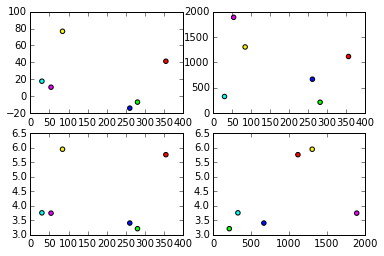

In [28]:

fig=plt.figure(1)
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)
ax4=fig.add_subplot(224)
lon = [item[0] for item in pseudo_evs]
lat = [item[1] for item in pseudo_evs]
time = [item[3] for item in pseudo_evs]
mag = [item[2] for item in pseudo_evs]

cmap = cm.get_cmap('hsv')
colors=[cmap(1.*i/(len(pseudo_evs))) for i in range(len(pseudo_evs))]


loc = ax1.scatter(lon,lat,c=colors)
lonvtime = ax2.scatter(lon,time,c=colors)
lonvmag = ax3.scatter(lon,mag,c=colors)
timevmag = ax4.scatter(time,mag,c=colors)
print cluster_indices
for ev in pseudo_evs:
    print ev

In [21]:
print
for lst in cluster_indices:
    for elm in lst:
        print pseudo_evs[elm]
        
for i in episodes:
    print len(i.detections)


[355.908432804, 41.293739142837794, 5.76413466855, 1115.03448594, 6, 6]
[84.2086106161, 76.732552032431244, 5.95273893608, 1302.84748776, 8, 8]
[281.288596903, -7.0650209929277343, 3.21112634662, 213.190633889, 2, 54]
[261.079969401, -14.182329633400247, 3.4052078982, 667.354641089, 6, 72]
97
95
87
107
93
91
90
86
95
88
93
93
105
97
105
122
102
103
99
86
118
82
109
96
83
88
127
102
108
90
92
113
89
83
100
113
93
90
108
117
105
106
83
105
103
107
101
85
101
98
80
86
90
113
94
116
91
111
119
97
131
102
95
90
97
89
101
84
97
118
97
107
107
104
96
104
94
104
103
109
102
100
131
99
90
100
90
103
100
85
95
110
90
108
102
101
106
103
103
75


[Event(lon=50.610285881261433, lat=39.448477497739155, mag=5.8584368023149995, time=1208.94098685), Event(lon=87.802933278787123, lat=79.519589641100069, mag=3.30816712241, time=440.272637489)]


[Event(lon=12.742965722834132, lat=64.127391465731364, mag=5.8584368023149995, time=1208.94098685), Event(lon=-88.69661101603262, lat=-10.787124159295345, mag=3.30816712241, time=440.272637489)]


ValueError: I/O operation on closed file